<a href="https://colab.research.google.com/github/HuyKhoi-code/AI_project/blob/master/inceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
! git clone https://github.com/hcmcaic/ai4vn-hackathon-2020.git ai4vn

fatal: destination path 'ai4vn' already exists and is not an empty directory.


In [ ]:
% cd ai4vn

/content/ai4vn


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import zipfile

from dataloader import path_to_image
from dataloader import image_dataset_from_directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
!unzip /content/drive/MyDrive/shizuka_data.zip -d /content/drive/MyDrive

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/sample_data/4/003370.jpg  
  inflating: /content/drive/MyDrive/sample_data/1/001988.jpg  
  inflating: /content/drive/MyDrive/sample_data/4/003373.jpg  
  inflating: /content/drive/MyDrive/sample_data/0/08635.jpg  
  inflating: /content/drive/MyDrive/sample_data/5/003662.jpg  
  inflating: /content/drive/MyDrive/sample_data/7/004796.jpg  
  inflating: /content/drive/MyDrive/sample_data/2/002295.jpg  
  inflating: /content/drive/MyDrive/sample_data/6/004437.jpg  
  inflating: /content/drive/MyDrive/sample_data/2/002109.jpg  
  inflating: /content/drive/MyDrive/sample_data/5/003949.jpg  
  inflating: /content/drive/MyDrive/sample_data/2/002104.jpg  
  inflating: /content/drive/MyDrive/sample_data/0/08637.jpg  
  inflating: /content/drive/MyDrive/sample_data/6/004345.jpg  
  inflating: /content/drive/MyDrive/sample_data/1/001958.jpg  
  inflating: /content/drive/MyDrive/sample_data/0/08551.jpg  
  infla

In [20]:
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras import optimizers

In [60]:
BATCH_SIZE = 10
IMG_SIZE = (299, 299)

NUM_CLASS = 8
IMG_SHAPE = IMG_SIZE + (3,)

In [61]:
path_to_data = '/content/drive/MyDrive/sample_data'


train_dataset, train_dataset_filenames = image_dataset_from_directory(path_to_data,
                                             validation_split=0.2,
                                             subset="training",
                                             shuffle=True,
                                             seed=505,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 5287 files belonging to 8 classes.
Using 4230 files for training.


In [62]:
validation_dataset, validation_dataset_filenames = image_dataset_from_directory(path_to_data,
                                                  validation_split=0.2,
                                                  subset="validation",
                                                  shuffle=True,
                                                  seed=505,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 5287 files belonging to 8 classes.
Using 1057 files for validation.


In [63]:
validation_dataset.class_names

['0', '1', '2', '3', '4', '5', '6', '7']

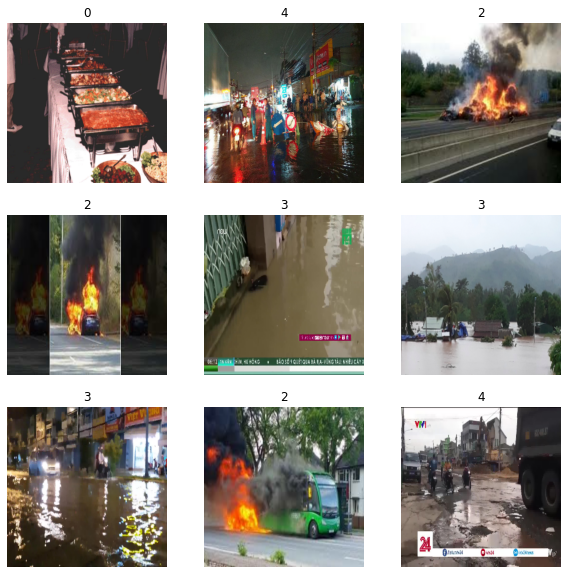

In [64]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [65]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [66]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

299


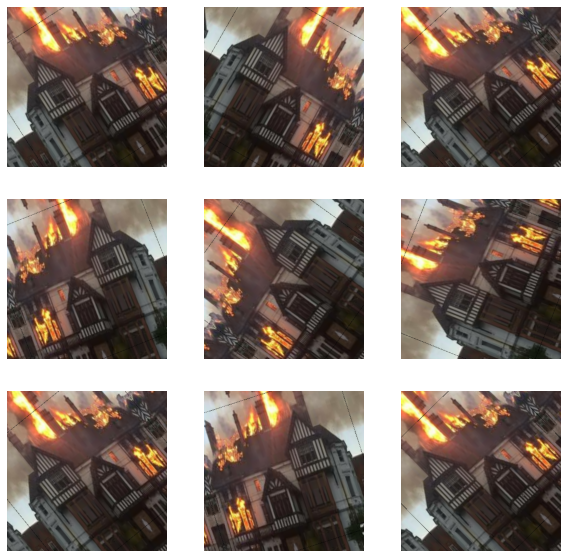

In [67]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  print(len(first_image))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [68]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [69]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [70]:
base_model = InceptionV3(input_shape=IMG_SHAPE,
                        include_top=False,
                        weights='imagenet')

In [71]:
base_model.trainable = False

In [72]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [73]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 8, 8, 2048)


In [74]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 2048)


In [75]:
prediction_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 8)


In [76]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [77]:
base_learning_rate = 0.0001
opt = tf.keras.optimizers.Adam(lr=base_learning_rate)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [78]:
len(model.trainable_variables)

4

In [79]:
initial_epochs = 10

In [80]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
423/423 [==============================] - 43s 101ms/step - loss: 1.6118 - accuracy: 0.6920 - val_loss: 1.4361 - val_accuracy: 0.8808
Epoch 2/10
423/423 [==============================] - 42s 99ms/step - loss: 1.4289 - accuracy: 0.8712 - val_loss: 1.4010 - val_accuracy: 0.8940
Epoch 3/10
423/423 [==============================] - 42s 99ms/step - loss: 1.3973 - accuracy: 0.8924 - val_loss: 1.3669 - val_accuracy: 0.9272
Epoch 4/10
423/423 [==============================] - 42s 99ms/step - loss: 1.3769 - accuracy: 0.9109 - val_loss: 1.3608 - val_accuracy: 0.9347
Epoch 5/10
423/423 [==============================] - 42s 100ms/step - loss: 1.3691 - accuracy: 0.9147 - val_loss: 1.3529 - val_accuracy: 0.9376
Epoch 6/10
423/423 [==============================] - 42s 100ms/step - loss: 1.3655 - accuracy: 0.9189 - val_loss: 1.3495 - val_accuracy: 0.9376
Epoch 7/10
423/423 [==============================] - 42s 99ms/step - loss: 1.3528 - accuracy: 0.9303 - val_loss: 1.3437 - val_accura

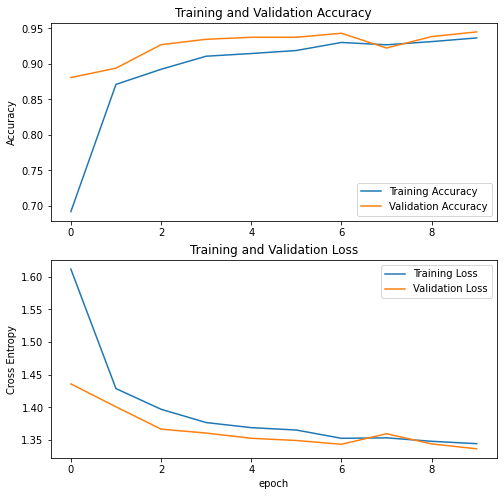

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [82]:
base_model.trainable = True

In [83]:

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 249

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  311


In [84]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [85]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)             

In [86]:
len(model.trainable_variables)

40

In [87]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
423/423 [==============================] - 45s 106ms/step - loss: 1.3322 - accuracy: 0.9461 - val_loss: 1.3210 - val_accuracy: 0.9565
Epoch 11/20
423/423 [==============================] - 44s 103ms/step - loss: 1.3198 - accuracy: 0.9584 - val_loss: 1.3238 - val_accuracy: 0.9527
Epoch 12/20
423/423 [==============================] - 44s 103ms/step - loss: 1.3165 - accuracy: 0.9605 - val_loss: 1.3137 - val_accuracy: 0.9612
Epoch 13/20
423/423 [==============================] - 44s 104ms/step - loss: 1.3080 - accuracy: 0.9671 - val_loss: 1.3154 - val_accuracy: 0.9593
Epoch 14/20
423/423 [==============================] - 44s 104ms/step - loss: 1.3048 - accuracy: 0.9704 - val_loss: 1.3138 - val_accuracy: 0.9612
Epoch 15/20
423/423 [==============================] - 44s 103ms/step - loss: 1.3001 - accuracy: 0.9759 - val_loss: 1.3133 - val_accuracy: 0.9631
Epoch 16/20
423/423 [==============================] - 44s 103ms/step - loss: 1.3018 - accuracy: 0.9728 - val_loss: 1.3151 -

In [88]:
model.save('/content/drive/MyDrive/inceptionv3_best.h5')

In [16]:
#model = load_model('/content/drive/MyDrive/inceptionv3.h5')

In [90]:
from dataloader import path_to_image
paths = os.listdir('/content/drive/MyDrive/data/')
test_dataset = []
final_predictions = []
final_path = []
true_class = []
count = 0
for folder in paths:
  path = '/content/drive/MyDrive/data/' + folder + '/'
  for i in os.listdir(path):
    img= path_to_image(path+i,(299,299),3,'bilinear')
    true_class.append(folder)
    new_img = np.expand_dims(img,0)
    prediction = model.predict(new_img)
    pre = np.argmax(prediction, axis=-1)
    final_predictions.append(pre)
    final_path.append(path+i)
    if count%100 == 0:
      print(count)
    count+=1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200


In [91]:
print (len(final_predictions))

1215


In [92]:
predict = []
for pred in final_predictions:
  predict.append(class_names[pred[0]])

In [93]:
from sklearn.metrics import confusion_matrix

In [94]:
conf_mat_rfc = confusion_matrix(true_class, predict, labels = class_names)

In [95]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix',export_as='confusion_matrix', cmap='Oranges'):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16, color="white")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,  classes, rotation=0, fontsize=12, color="white")
    plt.yticks(tick_marks,  classes, fontsize=12, color="white")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=18, color = 'white')
    plt.xlabel('Predicted labels', fontsize=18, color="white")

Normalized confusion matrix


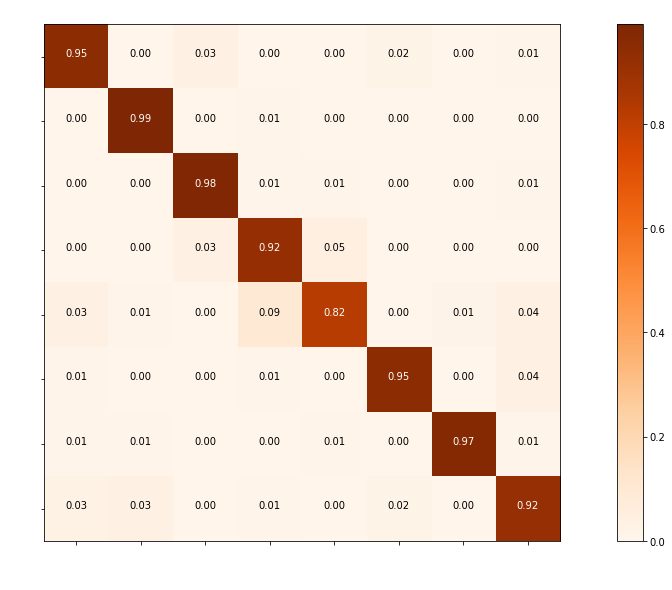

In [96]:
cm_plot_labels = class_names

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat_rfc, cm_plot_labels, normalize=True,
                      title="Confusion Matrix "
                     )

plt.show()

In [97]:
model = load_model('/content/drive/MyDrive/model_inception_basline_85.h5')

In [98]:
from dataloader import path_to_image
paths = os.listdir('/content/drive/MyDrive/data/')
test_dataset = []
final_predictions = []
final_path = []
true_class = []
count = 0
for folder in paths:
  path = '/content/drive/MyDrive/data/' + folder + '/'
  for i in os.listdir(path):
    img= path_to_image(path+i,(299,299),3,'bilinear')
    true_class.append(folder)
    new_img = np.expand_dims(img,0)
    prediction = model.predict(new_img)
    pre = np.argmax(prediction, axis=-1)
    final_predictions.append(pre)
    final_path.append(path+i)
    if count%100 == 0:
      print(count)
    count+=1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200


In [99]:
predict = []
for pred in final_predictions:
  predict.append(class_names[pred[0]])

In [100]:
conf_mat_rfc = confusion_matrix(true_class, predict, labels = class_names)

In [101]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix',export_as='confusion_matrix', cmap='Oranges'):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16, color="white")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,  classes, rotation=0, fontsize=12, color="white")
    plt.yticks(tick_marks,  classes, fontsize=12, color="white")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=18, color = 'white')
    plt.xlabel('Predicted labels', fontsize=18, color="white")

Normalized confusion matrix


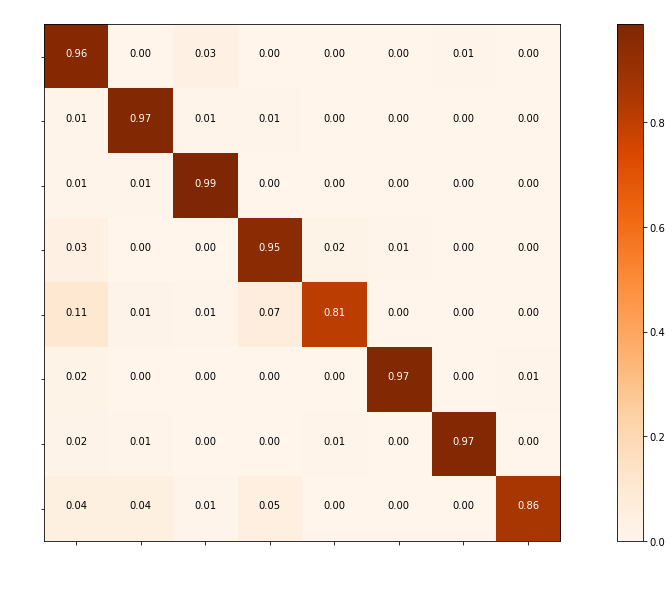

In [102]:
cm_plot_labels = class_names

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat_rfc, cm_plot_labels, normalize=True,
                      title="Confusion Matrix "
                     )

plt.show()